<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-4-Sprint-1-NLP/blob/main/module2-vector-representations/LS_DS17_412_Vector_Representations_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 4, Sprint 1, Module 2*

---

# Vector Representations (Prepare)


As we learned yesterday, machines cannot interpret raw text. We need to transform that text into something we/machines can more readily analyze. Yesterday, we did simple counts of counts to summarize the content of Amazon reviews. Today, we'll extend those concepts to talk about vector representations such as Bag of Words (BoW) and word embedding models. We'll use those representations for search, visualization, and prepare for our classification day tomorrow. 

Processing text data to prepare it for machine learning models often means translating the information from documents into a numerical format. Bag-of-Words approaches (sometimes referred to as Frequency-Based word embeddings) accomplish this by "vectorizing" tokenized documents. This is done by representing each document as a row in a DataFrame and creating a column for each unique word in the corpora (group of documents). The presence or lack of a given word in a document is then represented either as a raw count of how many times a given word appears in a document (CountVectorizer) or as that word's TF-IDF score (TfidfVectorizer).

On the python side, we will be focusing on `sklearn` and `spacy` today.  

## Case Study

We're going to pretend we're on the datascience team at the BBC. We want to recommend articles to visitors to on the BBC website based on the article they just read. Our team wants 

**Dataset:**

[D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.](http://mlg.ucd.ie/datasets/bbc.html)
*Please note that the dataset has been sampled down to tech articles only.* 

## Learning Objectives
* <a href="#p1">Part 1</a>: Represent a document as a vector
* <a href="#p2">Part 2</a>: Query Documents by Similarity
* <a href="#p3">Part 3</a>: Apply word embedding models to create document vectors

# Represent a document as a vector (Learn)
<a id="p1"></a>

## Overview

In this section, we are going to create Document Term Matrices (DTM). Each column represents a word. Each row represents a document. The value in each cell can be range of different things. The most traditional: counts of appearances of words, does the word appear at all (binary), and term-frequency inverse-document frequency (TF-IDF). 

**Discussion:** Don't we loose all the context and grammar if we do this? So Why does it work?

## Follow Along

### Vectorizers:
There are different ways to convert a text to a set of number vectors:
1. CountVectorizer(stop_words='english', max_features=1000) with fit and transform methods to learn the vocab and create a data term matrix (dtm), when each row is one docuement and the columns are the vocab (features) and the values are the frequency of the words in that document
2. TfidfVectorizer(stop_words='english', max_features=5000) tf-idf is the count of a word in that document scaled down by the count of the documents that have that word.
3. tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=.97, min_df=.01,
tokenizer=tokenize) uses spacy based data pipeline tokenizer instead of default sklearn tokenizer, allowing to us .lemma_, .is_punct, .is_stop methods
4. Use sklearn.metrics.pairwise.cosine_similarity(dtm) to find which rows are more similar.
5. Use NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dtm) to find similar articles. Can use dtm_query=tfidf.transform(query_text) to prepare input for nn.kneighbors(dtm_query.todense())
6. Instead of bag of word vectorizers, use word embedding to preserve textual context. Spacy's nlp.vector produces a 300 dimension vector for any text. We can also use text1.similarity(nlp(text2)) to get the similarity of two documents
7. Use PCA to reduce spacy 300 dimension vectors for visualization pca=PCA(n_components=2) > pca.fit(nlp(text_list).vector) > word_vecs_2d = pca.transform(nlp(text_query).vector)
8. We can embedd each row(article) with spacy 300 ndim vector X = [nlp(str(d)).vector for d in data] , and then run NearestNeighbors().fit(X) > nn.kneighbors(nlp(query_text).vector)to find similar articles




In [1]:
# import spacy model as a package for colab and restart the run time afterwards
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-2.3.1/en_core_web_lg-2.3.1.tar.gz

     |████████████████████████████████| 782.7MB 21kB/s 
     |████████████████████████████████| 10.0MB 3.0MB/s 
     |████████████████████████████████| 2.1MB 42.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.3.1-cp36-none-any.whl size=782936125 sha256=293ccd39f6949fc66ab954a1784ceb08358e18547e6e8008098a3a870c03cb28
  Stored in directory: /root/.cache/pip/wheels/ce/4d/1b/bc6cabb6df139c5f0318927be3ae9e51363fb44d6ea328d3f4
Successfully built en-core-web-lg
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [1]:
""" Import Statements """

# Classics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_lg")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Warm Up (_3 Minutes_)**

Extract the tokens from this sentence using Spacy. Text is from [OpenAI](https://openai.com/blog/better-language-models/)

In [6]:
text = """GPT-2 displays a broad set of capabilities, including 
the ability to generate conditional synthetic text samples of 
unprecedented quality, where we prime the model with an input and 
have it generate a lengthy continuation. In addition, GPT-2 outperforms 
other language models trained on specific domains 
(like Wikipedia, news, or books) without needing to use these domain-specific 
training datasets. On language tasks like question answering, reading 
comprehension, summarization, and translation, GPT-2 begins to learn these 
tasks from the raw text, using no task-specific training data. 
While scores on these downstream tasks are far from state-of-the-art, 
they suggest that the tasks can benefit from unsupervised techniques, 
given sufficient (unlabeled) data and compute.          $%&*?"""

In [7]:
# nlp create a spacy.Doc word iterable (tokenizable) data type with a several methodes
doc = nlp(text)
doc

GPT-2 displays a broad set of capabilities, including 
the ability to generate conditional synthetic text samples of 
unprecedented quality, where we prime the model with an input and 
have it generate a lengthy continuation. In addition, GPT-2 outperforms 
other language models trained on specific domains 
(like Wikipedia, news, or books) without needing to use these domain-specific 
training datasets. On language tasks like question answering, reading 
comprehension, summarization, and translation, GPT-2 begins to learn these 
tasks from the raw text, using no task-specific training data. 
While scores on these downstream tasks are far from state-of-the-art, 
they suggest that the tasks can benefit from unsupervised techniques, 
given sufficient (unlabeled) data and compute.          $%&*?

In [9]:
"""lemma_ convert words to their roots and normalizes 
the verb tense and nounes, removes stop words, pronounces"""

[token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)]

['GPT-2',
 'display',
 'broad',
 'set',
 'capability',
 'include',
 '\n',
 'ability',
 'generate',
 'conditional',
 'synthetic',
 'text',
 'sample',
 '\n',
 'unprecedented',
 'quality',
 'prime',
 'model',
 'input',
 '\n',
 'generate',
 'lengthy',
 'continuation',
 'addition',
 'GPT-2',
 'outperform',
 '\n',
 'language',
 'model',
 'train',
 'specific',
 'domain',
 '\n',
 'like',
 'Wikipedia',
 'news',
 'book',
 'need',
 'use',
 'domain',
 'specific',
 '\n',
 'training',
 'dataset',
 'language',
 'task',
 'like',
 'question',
 'answering',
 'read',
 '\n',
 'comprehension',
 'summarization',
 'translation',
 'GPT-2',
 'begin',
 'learn',
 '\n',
 'task',
 'raw',
 'text',
 'task',
 'specific',
 'training',
 'datum',
 '\n',
 'score',
 'downstream',
 'task',
 'far',
 'state',
 'art',
 '\n',
 'suggest',
 'task',
 'benefit',
 'unsupervised',
 'technique',
 '\n',
 'give',
 'sufficient',
 'unlabeled',
 'datum',
 'compute',
 '         ',
 '$']

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
/content/drive/My Drive/Colab Notebooks/Lambda School/Unit-4-Sprint-1-NLP/data

In [16]:
import os 
# os.listdir('./data')
# os.listdir('/content/drive/My Drive/Colab Notebooks/Lambda School/Unit-4-Sprint-1-NLP/data')

In [17]:
# use lower case action verbs for functions

def gather_data(filefolder):
    """ Produces List of Documents from a Directory
    
    filefolder (str): a path to .txt files
    
    returns list of strings, where each string is one content of one file
    """
    
    data = []
    
    files = os.listdir(filefolder) # Causes variation across machines
    
    for article in files: 
        
        path = os.path.join(filefolder, article)
                    
        if  path[-3:] == 'txt': # os ~endswith('txt')
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [18]:
data = gather_data('/content/drive/My Drive/Colab Notebooks/Lambda School/Unit-4-Sprint-1-NLP/data')

In [22]:
print(len(data))
data[0][:100]

401


b"Security warning over 'FBI virus'\n\nThe US Federal Bureau of Investigation is warning that a computer"

In [ ]:
# Convert byte type to string
data = [i.decode("utf-8") for i in data]

### CountVectorizer
* CountVectorizer creates a document term matrix (dtm) in which the value in each cell represents the count of the appearance of that word in the document each row represents

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# list of 3 text documents
text = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.",
        " In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma., This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny)", 
        "leading to higher data quality than other similar datasets, such as CommonCrawl."]

# create the transformer
vect = CountVectorizer()

# build vocab
vect.fit(text)

# transform text
dtm = vect.transform(text)

# Create a Vocabulary
# The vocabulary establishes all of the possible words that we might use.

# The vocabulary dictionary does not represent the counts of words!!


In [27]:
dir(vect)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_char_ngrams',
 '_char_wb_ngrams',
 '_check_stop_words_consistency',
 '_check_vocabulary',
 '_count_vocab',
 '_get_param_names',
 '_get_tags',
 '_limit_features',
 '_more_tags',
 '_sort_features',
 '_stop_words_id',
 '_validate_custom_analyzer',
 '_validate_params',
 '_validate_vocabulary',
 '_warn_for_unused_params',
 '_white_spaces',
 '_word_ngrams',
 'analyzer',
 'binary',
 'build_analyzer',
 'build_preprocessor',
 'build_tokenizer',
 'decode',
 'decode_error',
 'dtype',
 'encoding',
 'fit',
 'fit_transform',
 'fixed_vocabulary_',
 'get_feature_names',
 'get_params',
 'get_stop_words'

In [44]:
print(vect.get_feature_names())
print(len(vect.get_feature_names()))

['as', 'at', 'be', 'been', 'by', 'can', 'commoncrawl', 'content', 'created', 'curated', 'data', 'dataset', 'datasets', 'diversity', 'document', 'educational', 'emphasizes', 'filtered', 'for', 'found', 'from', 'funny', 'have', 'heuristic', 'higher', 'humans', 'in', 'indicator', 'interesting', 'internet', 'karma', 'leading', 'least', 'link', 'links', 'new', 'of', 'only', 'or', 'order', 'other', 'outbound', 'pages', 'preserve', 'quality', 'received', 'reddit', 'scraping', 'similar', 'specifically', 'such', 'than', 'the', 'this', 'thought', 'to', 'used', 'users', 'we', 'whether', 'which']
61


In [45]:
#(document, word_index) count
print(type(dtm))
print(dtm)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 4)	1
  (0, 7)	2
  (0, 8)	1
  (0, 11)	1
  (0, 13)	1
  (0, 16)	1
  (0, 20)	1
  (0, 29)	1
  (0, 35)	1
  (0, 36)	1
  (0, 47)	1
  (0, 52)	1
  (0, 58)	1
  (0, 60)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 9)	1
  (1, 14)	1
  (1, 15)	1
  (1, 17)	1
  (1, 18)	1
  :	:
  (1, 44)	1
  (1, 45)	1
  (1, 46)	1
  (1, 49)	1
  (1, 52)	1
  (1, 53)	1
  (1, 54)	1
  (1, 55)	1
  (1, 56)	2
  (1, 57)	1
  (1, 58)	2
  (1, 59)	2
  (1, 60)	2
  (2, 0)	1
  (2, 6)	1
  (2, 10)	1
  (2, 12)	1
  (2, 24)	1
  (2, 31)	1
  (2, 40)	1
  (2, 44)	1
  (2, 48)	1
  (2, 50)	1
  (2, 51)	1
  (2, 55)	1


In [40]:
# there are total of 61 words for all 3 text documents
dtm.todense().shape

(3, 61)

In [ ]:
# Dealing with Sparse Matrix
# dtm shows which word in dictionary is used in each document and how many times
print(dtm.todense().shape)
dtm.todense()

matrix([[0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
         1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 1, 2, 2, 2],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [46]:
type(dtm)

scipy.sparse.csr.csr_matrix

In [47]:
# Get Word Counts for each document
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,as,at,be,been,by,can,commoncrawl,content,created,curated,data,dataset,datasets,diversity,document,educational,emphasizes,filtered,for,found,from,funny,have,heuristic,higher,humans,in,indicator,interesting,internet,karma,leading,least,link,links,new,of,only,or,order,other,outbound,pages,preserve,quality,received,reddit,scraping,similar,specifically,such,than,the,this,thought,to,used,users,we,whether,which
0,0,0,0,0,1,0,0,2,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1
1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,1,1,1,2,1,2,2,2
2,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0


In [48]:
# back to bbc dataset
data[0][:25]

b"Security warning over 'FB"

In [49]:
# number of articles
len(data)

401

**Three Minute Challenge:** 
* Apply CountVectorizer to our BBC Data
* Store results in a dataframe called `dtm`
* Extra Challenge - Try to Customize CountVectorizer with Spacy Processing

In [51]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer
# BBC articles in `data` variable

from sklearn.feature_extraction.text import CountVectorizer
# instantiate the countvectorizer class
vect = CountVectorizer(stop_words='english', max_features=1000)

#Learn our Vocab
# data is a list of strings
vect.fit(data)

# Get sparse dtm
dtm = vect.transform(data)

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [52]:
# sparse matrix
dtm.head()

,000,10,100,11,12,14,15,18,20,200,2003,2004,2005,2006,25,30,3d,3g,40,50,500,60,80,ability,able,access,according,account,accounts,act,action,activity,actually,add,added,address,addresses,advantage,age,ago,...,wanted,wants,warned,warning,wars,watch,watching,way,ways,web,website,websites,week,weeks,went,wi,wide,widely,win,windows,wireless,women,won,word,words,work,worked,working,works,world,worldwide,worm,worth,writing,xbox,xp,yahoo,year,years,york
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,1,0,1,0,3,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2,0,2,0,0,0,0,0,0,0,1,0,0


In [53]:
doc_len = [len(doc) for doc in data]

str = '...' literals = a sequence of Unicode characters (UTF-16 or UTF-32, depending on how Python was compiled)

bytes = b'...' literals = a sequence of octets (integers between 0 and 255)

In [57]:
type(data[0])

bytes

In [54]:
# number of words 
doc_len[0]

1300

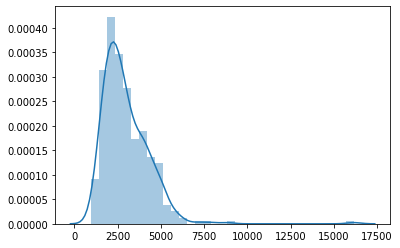

In [58]:
import seaborn as sns
# y axis is density plot
sns.distplot(doc_len);

### TfidfVectorizer

## Term Frequency - Inverse Document Frequency (TF-IDF)

<center><img src="https://mungingdata.files.wordpress.com/2017/11/equation.png?w=430&h=336" width="300"></center>

Term Frequency: Percentage of words in document for each word

Document Frequency: A penalty for the word existing in a high number of documents.

The purpose of TF-IDF is to find what is **unique** to each document. Because of this we will penalize the term frequencies of words that are common across all documents which will allow for each document's most different topics to rise to the top.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf.fit_transform(data)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,000,10,100,101,104,10m,11,12,120,13,...,yoda,yoran,york,young,younger,youngsters,youth,zafi,zen,zombies
0,0.028940,0.066646,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.05528,0.058505,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.077901,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.061896,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
def tokenize(document):
    
    doc = nlp(document)
    
    # strip() removes white space from beginning or end of the string
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [66]:
# decoding byte type to string
data[0].decode("utf-8") 

'Security warning over \'FBI virus\'\n\nThe US Federal Bureau of Investigation is warning that a computer virus is being spread via e-mails that purport to be from the FBI.\n\nThe e-mails show that they have come from an fbi.gov address and tell recipients that they have accessed illegal websites. The messages warn that their internet use has been monitored by the FBI\'s Internet Fraud Complaint Center. An attachment in the e-mail contains the virus, the FBI said. The message asks recipients to click on the attachment and answer some questions about their internet use. But rather than being a questionnaire, the attachment contains a virus that infects the recipient\'s computer, according to the agency. It is not clear what the virus does once it has infected a computer. Users are warned never to open attachment from unsolicited e-mails or from people they do not know.\n\n"Recipients of this or similar solicitations should know that the FBI does not engage in the practice of sending uns

In [67]:
data[0]

b'Security warning over \'FBI virus\'\n\nThe US Federal Bureau of Investigation is warning that a computer virus is being spread via e-mails that purport to be from the FBI.\n\nThe e-mails show that they have come from an fbi.gov address and tell recipients that they have accessed illegal websites. The messages warn that their internet use has been monitored by the FBI\'s Internet Fraud Complaint Center. An attachment in the e-mail contains the virus, the FBI said. The message asks recipients to click on the attachment and answer some questions about their internet use. But rather than being a questionnaire, the attachment contains a virus that infects the recipient\'s computer, according to the agency. It is not clear what the virus does once it has infected a computer. Users are warned never to open attachment from unsolicited e-mails or from people they do not know.\n\n"Recipients of this or similar solicitations should know that the FBI does not engage in the practice of sending un

text data machines

"text data" "data machines" "text machines"

In [97]:
# Tunning Parameters

# Instantiate vectorizer object with nlp data pipeline based tokenizer instead of default sklearn tokenizer
tfidf = TfidfVectorizer(ngram_range=(1,2),
                        max_df=.97,
                        min_df=.01,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(data) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,10,2004,accord,add,apple,bbc,big,bill,britain,bt,call,clark,company,computer,consumer,currently,despite,digital,early,end,european,fact,fast,figure,film,firm,game,gamer,generation,group,half,high,image,internet,key,late,launch,legal,like,man,...,worried,worry,worth,worthwhile,wow,write,writer,writing,wrong,x,xbox,xbox,xbox 2,xbox games,xbox live,xp,yahoo,year,year,year accord,year ago,year end,year go,year new,year number,year old,year say,year time,yen,yes,york,young,young people,youth,zombie,zone,zoom,£,£ 20,£ 99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132738,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Challenge

During this module's project assignment, you will transform data science job listings to vector representations for analysis downstream. 

In [98]:
# list dataframe column names
# some of them are bigram
list(dtm)[300:350]

['alliance',
 'allow',
 'allow people',
 'allow user',
 'alongside',
 'alter',
 'alternative',
 'amazing',
 'amazon',
 'amazon.com',
 'amazon.com hold',
 'ambitious',
 'america',
 'american',
 'american life',
 'americans',
 'amount',
 'amount datum',
 'analogue',
 'analyse',
 'analysis',
 'analysis firm',
 'analyst',
 'analyst bill',
 'analyst gartner',
 'analyst jupiter',
 'andreas',
 'andrew',
 'angeles',
 'angle',
 'announce',
 'announcement',
 'annual',
 'anomaly',
 'anonymous',
 'answer',
 'answer question',
 'anti',
 'anti piracy',
 'anti spam',
 'anti spyware',
 'anti virus',
 'anticipate',
 'aol',
 'apart',
 'appeal',
 'appeal people',
 'appear',
 'appearance',
 'apple']

# Query Documents by Similarity (Learn)
<a id="p2"></a>

## Overview

Have you ever considered how a search bar works? You may just think that search bars simply match your input text againist the documents. While there are many different mechanisms for the 'match', one of the most classic is to search by similarity. We will apply n-dimensional distance to measure similarity, and query for input and output. 

## Follow Along

### Cosine Similarity (Brute Force)
Cosine similarity is the cosine of the angle between two n-dimensional vectors in an n-dimensional space. It is the dot product of the two vectors divided by the product of the two vectors' lengths

In [78]:
dtm.shape

(401, 3823)

In [99]:
# Calculate alignment of equivalent TF-IDF Vectors of different rows to find the ones similar to eachother
from sklearn.metrics.pairwise import cosine_similarity

dist_matrix  = cosine_similarity(dtm)

In [100]:
# Turn it into a DataFrame

df = pd.DataFrame(dist_matrix)

In [101]:
# Our Similarity Matrix size between different articles
df.shape

(401, 401)

In [102]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400
0,1.000000,0.007983,0.173512,0.008303,0.014658,0.031357,0.014410,0.031357,0.014783,0.016000,0.049697,0.043407,0.030473,0.148614,0.023735,0.005388,0.023340,0.031865,0.031975,0.043191,0.030613,0.019523,0.043841,0.040002,0.003788,0.092328,0.096815,0.007610,0.186476,0.010411,0.033295,0.023892,0.006377,0.017275,0.003724,0.040325,0.020990,0.022608,0.064564,0.012493,...,0.014866,0.039327,0.027663,0.019461,0.056628,0.027618,0.022105,0.234520,0.031933,0.036329,0.035778,0.210616,0.018955,0.044851,0.014467,0.014981,0.077240,0.009540,0.062648,0.034034,0.016340,0.007864,0.023758,0.008828,0.016233,0.013513,0.036153,0.109456,0.027396,0.039327,0.043911,0.023754,0.346771,0.042760,0.042297,0.031292,0.105798,0.041452,0.096806,0.017374
1,0.007983,1.000000,0.019687,0.032705,0.026539,0.007660,0.012039,0.007660,0.080080,0.087536,0.045198,0.028319,0.030338,0.029138,0.174444,0.070909,0.044126,0.030298,0.081250,0.041224,0.038735,0.058860,0.045716,0.009669,0.119626,0.018138,0.054261,0.072040,0.027251,0.055767,0.049333,0.025371,0.131575,0.058266,0.084497,0.017349,0.056626,0.041286,0.016267,0.132756,...,0.051979,0.033547,0.011530,0.069564,0.060272,0.023020,0.033833,0.030496,0.059768,0.021936,0.082468,0.015538,0.065636,0.045783,0.026637,0.047479,0.049405,0.044733,0.043300,0.013952,0.143509,0.025961,0.022701,0.060823,0.039861,0.036459,0.059480,0.031329,0.072385,0.033547,0.048483,0.020009,0.031649,0.084292,0.011366,0.042601,0.038556,0.018657,0.025061,0.023293
2,0.173512,0.019687,1.000000,0.026978,0.103694,0.040642,0.027159,0.040642,0.078788,0.068835,0.090774,0.066398,0.042604,0.264061,0.052097,0.022854,0.035763,0.100152,0.059767,0.053776,0.074056,0.065418,0.072250,0.091183,0.030739,0.067601,0.131622,0.023147,0.044047,0.058901,0.076487,0.078168,0.045343,0.114725,0.028697,0.054346,0.071264,0.070136,0.112465,0.053839,...,0.108973,0.081411,0.065407,0.070206,0.128968,0.071203,0.050151,0.152503,0.077407,0.097544,0.105406,0.177114,0.092531,0.140166,0.080632,0.096911,0.040250,0.043999,0.123470,0.077355,0.057939,0.091874,0.107757,0.043959,0.100169,0.069790,0.081199,0.125117,0.069108,0.081411,0.112906,0.046731,0.167223,0.072727,0.053087,0.172404,0.245653,0.137081,0.074730,0.098713
3,0.008303,0.032705,0.026978,1.000000,0.132964,0.022498,0.022727,0.022498,0.046600,0.039550,0.044200,0.037144,0.023134,0.016503,0.016529,0.020721,0.048534,0.034637,0.041164,0.038978,0.033302,0.068467,0.066472,0.036108,0.033178,0.023850,0.050222,0.028843,0.032025,0.280015,0.020904,0.024904,0.046674,0.029044,0.413554,0.026776,0.019523,0.152631,0.058326,0.053882,...,0.048432,0.027855,0.010185,0.024081,0.026362,0.026163,0.064072,0.034133,0.066841,0.032754,0.079621,0.019225,0.058714,0.090335,0.022342,0.053787,0.016555,0.089508,0.044669,0.037388,0.057164,0.016711,0.043067,0.024373,0.278724,0.141192,0.197374,0.054097,0.092043,0.027855,0.059859,0.013478,0.015475,0.070276,0.031190,0.052683,0.017214,0.047006,0.044875,0.021640
4,0.014658,0.026539,0.103694,0.132964,1.000000,0.018419,0.035706,0.018419,0.052324,0.039976,0.065683,0.042230,0.024059,0.031813,0.012394,0.034867,0.033039,0.045486,0.065513,0.044268,0.035749,0.037512,0.041081,0.088712,0.015808,0.026840,0.039614,0.038249,0.024064,0.076236,0.031635,0.030562,0.015171,0.037228,0.040144,0.047063,0.023581,0.053636,0.059721,0.044492,...,0.059680,0.020254,0.023250,0.090503,0.052922,0.033967,0.032230,0.057013,0.070465,0.032280,0.048541,0.013493,0.039321,0.050005,0.053786,0.048857,0.039509,0.054475,0.053478,0.025497,0.041091,0.060583,0.054275,0.035392,0.053220,0.032520,0.060661,0.067213,0.064124,0.020254,0.090382,0.023297,0.049628,0.045833,0.024937,0.051019,0.063334,0.059665,0.052831,0.021081


In [103]:
# Each row is the similarity of one document to all other documents (including itself)
df[0][:5]

0    1.000000
1    0.007983
2    0.173512
3    0.008303
4    0.014658
Name: 0, dtype: float64

In [104]:
df[0]<1

0      False
1       True
2       True
3       True
4       True
       ...  
396     True
397     True
398     True
399     True
400     True
Name: 0, Length: 401, dtype: bool

In [105]:
# Grab the row the are similar to first article
df[df[0] < 1][0].sort_values(ascending=False)[:5]

355    0.503040
296    0.503040
249    0.501347
292    0.450250
393    0.346771
Name: 0, dtype: float64

In [107]:
print(data[0][:150])

Security warning over 'FBI virus'

The US Federal Bureau of Investigation is warning that a computer virus is being spread via e-mails that purport to


In [108]:
# related articles
print(data[355][:150])

Virus poses as Christmas e-mail

Security firms are warning about a Windows virus disguising itself as an electronic Christmas card.

The Zafi.D virus


### NearestNeighbor (K-NN) 

To address the computational inefficiencies of the brute-force approach, a variety of tree-based data structures have been invented. In general, these structures attempt to reduce the required number of distance calculations by efficiently encoding aggregate distance information for the sample. The basic idea is that if point  is very distant from point , and point  is very close to point , then we know that points  and  are very distant, without having to explicitly calculate their distance. In this way, the computational cost of a nearest neighbors search can be reduced to  or better. This is a significant improvement over brute-force for large data.

To address the inefficiencies of KD Trees in higher dimensions, the ball tree data structure was developed. Where KD trees partition data along Cartesian axes, ball trees partition data in a series of nesting hyper-spheres. This makes tree construction more costly than that of the KD tree, but results in a data structure which can be very efficient on highly structured data, even in very high dimensions.

A ball tree recursively divides the data into nodes defined by a centroid  and radius , such that each point in the node lies within the hyper-sphere defined by  and . The number of candidate points for a neighbor search is reduced through use of the triangle inequality:

With this setup, a single distance calculation between a test point and the centroid is sufficient to determine a lower and upper bound on the distance to all points within the node. Because of the spherical geometry of the ball tree nodes, it can out-perform a KD-tree in high dimensions, though the actual performance is highly dependent on the structure of the training data. In scikit-learn, ball-tree-based neighbors searches are specified using the keyword algorithm = 'ball_tree', and are computed using the class sklearn.neighbors.BallTree. Alternatively, the user can work with the BallTree class directly.

In [109]:
dtm.head()

,10,2004,accord,add,apple,bbc,big,bill,britain,bt,call,clark,company,computer,consumer,currently,despite,digital,early,end,european,fact,fast,figure,film,firm,game,gamer,generation,group,half,high,image,internet,key,late,launch,legal,like,man,...,worried,worry,worth,worthwhile,wow,write,writer,writing,wrong,x,xbox,xbox,xbox 2,xbox games,xbox live,xp,yahoo,year,year,year accord,year ago,year end,year go,year new,year number,year old,year say,year time,yen,yes,york,young,young people,youth,zombie,zone,zoom,£,£ 20,£ 99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132738,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [110]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [113]:
# gives the distance of each neighbor to the first neighbor (first row)
print(len(dtm.iloc[0]))   # tfidf vector of all articles with respect to the first article

print(type(dtm.iloc[0].values))
# returns a list of five nearest neighbors distance, and another list of those neighbors' row number
nn.kneighbors([dtm.iloc[0].values])

3823
<class 'numpy.ndarray'>


(array([[0.        , 0.        , 0.99695534, 0.99695534, 0.99865171]]),
 array([[  0,  85, 296, 355, 249]]))

In [114]:
data[0][:100]

"Security warning over 'FBI virus'\n\nThe US Federal Bureau of Investigation is warning that a computer"

In [115]:
data[85][:100]

"Security warning over 'FBI virus'\n\nThe US Federal Bureau of Investigation is warning that a computer"

In [116]:
# Query Using kneighbors:
nn.kneighbors([dtm.iloc[296].values])

(array([[0.        , 0.        , 0.83091051, 0.85535253, 0.99695534]]),
 array([[355, 296, 249, 292,  85]]))

In [117]:
rndm_tech_article = [ """
Blockchain technology encompasses so much more than just cryptocurrencies these days. And while these currencies are by far blockchain’s most famous use case, the potential for blockchain far, far exceeds a straightforward transfer of value.
The gaming industry, for example, has always been fairly controversial due to a range of issues. Many players feel particularly worried about the protection of their data, fraudulent activities, high fees, and most of all, unfair and hidden odds.
In these cases, P2P doesn’t just mean peer-to-peer; it means player-to-player. As with the other P2P industries that blockchain is disrupting, such as FinTech, there are already plenty of ways in which blockchain technology is being applied to resolve these issues and many more of the challenges faced by the gaming industry. Here are just a few.
Reducing fraud
The gaming industry suffers a lot from online fraud. One of the main advantages of blockchain technology is that it enables highly secure data encryption. What’s more, all of it is entirely accessible and transparent to the player. In other words, blockchain is a for game changer for venues such as online casinos, lotteries, and virtually anything which relies on random number generation.
On top of this, hackers will have particularly hard time, if it is even possible, to destroy a decentralized blockchain network, making sure gamer data stays safe. This is an inherent feature of distributed ledger technology whereby nodes in the ledger maintain the distributed databases in a shared manner, and each node has the complete information in the entire database.
"""]

In [118]:
# Query for Sim of Random doc to BBC
new_dtm = tfidf.transform(rndm_tech_article)

In [119]:
print(new_dtm.shape)
new_dtm

(1, 3823)


<1x3823 sparse matrix of type '<class 'numpy.float64'>'
	with 75 stored elements in Compressed Sparse Row format>

In [120]:
type(new_dtm.todense())

numpy.matrix

In [123]:
nn.kneighbors(new_dtm.todense())

(array([[1.27210862, 1.27220922, 1.2949672 , 1.29982272, 1.31042356]]),
 array([[389, 235, 394, 312, 232]]))

In [124]:
# Inspect Most relevant result
data[389]

'Peer-to-peer nets \'here to stay\'\n\nPeer-to-peer (P2P) networks are here to stay, and are on the verge of being exploited by commercial media firms, says a panel of industry experts.\n\nOnce several high-profile legal cases against file-sharers are resolved this year, firms will be very keen to try and make money from P2P technology. The expert panel probed the future of P2P at the Consumer Electronics Show in Las Vegas earlier in January. The first convictions for P2P piracy were handed out in the US in January. William Trowbridge and Michael Chicoine pleaded guilty to charges that they infringed copyright by illegally sharing music, movies and software. Since the first successful file-sharing network Napster was forced to close down, the entertainment industry has been nervous and critical of P2P technology, blaming it for falling sales and piracy. But that is going to change very soon, according to the panel.\n\nThe music and film industries have started some big legal cases agai

## Challenge

In the module project assignment, you will apply one of these search techniques to retrieve documents related to a query document. 

# Apply word embedding models to create document vectors (Learn)
<a id="p3"></a>

## Overview
### BoW discards textual context

One of the limitations of Bag-of-Words approaches is that any information about the textual context surrounding that word is lost. This also means that with bag-of-words approaches often the only tools that we have for identifying words with similar usage or meaning and subsequently consolidating them into a single vector is through the processes of stemming and lemmatization which tend to be quite limited at consolidating words unless the two words are very close in their spelling or in their root parts-of-speech.

### Embedding approaches preserve more textual context
Word2Vec is an increasingly popular word embedding technique. Like Bag-of-words it learns a real-value vector representation for a predefined fixed-size vocabulary that is generated from a corpus of text. However, in contrast to BoW, Word2Vec approaches are much more capable of accounting for textual context, and are better at discovering words with similar meanings or usages (semantic or syntactic similarity).

### Word2Vec Intuition
### The Distribution Hypothesis

In order to understand how Word2Vec preserves textual context we have to understand what's called the Distribution Hypothesis (Reference: Distribution Hypothesis Theory  -https://en.wikipedia.org/wiki/Distributional_semantics. The Distribution Hypothesis operates under the assumption that words that have similar contexts will have similar meanings. Practically speaking, this means that if two words are found to have similar words both to the right and to the left of them throughout the corpora then those words have the same context and are assumed to have the same meaning. 

> "You shall know a word by the company it keeps" - John Firth

This means that we let the usage of a word define its meaning and its "similarity" to other words. In the following example, which words would you say have a similar meaning? 

**Sentence 1**: Traffic was light today

**Sentence 2**: Traffic was heavy yesterday

**Sentence 3**: Prediction is that traffic will be smooth-flowing tomorrow since it is a national holiday

What words in the above sentences seem to have a similar meaning if all you knew about them was the context in which they appeared above? 

Lets take a look at how this might work in action, the following example is simplified, but will give you an idea of the intuition for how this works.

#### Corpora:

1) "It was the sunniest of days."

2) "It was the raniest of days."

#### Vocabulary:

{"it": 1, "was": 2, "the": 3, "of": 4, "days": 5, "sunniest": 6, "raniest": 7}

### Vectorization

|       doc   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | it_the | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|--------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0      | 0           | 0            | 0      |
| was      | 0         | 1      | 0            | 0      | 0             | 0     | 0        | 1      | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 0      | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0      | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0      | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |

Each column vector represents the word's context -in this case defined by the words to the left and right of the center word. How far we look to the left and right of a given word is referred to as our "window of context." Each row vector represents the the different usages of a given word. Word2Vec can consider a larger context than only words that are immediately to the left and right of a given word, but we're going to keep our window of context small for this example. What's most important is that this vectorization has translated our documents from a text representation to a numeric one in a way that preserves information about the underlying context. 

We can see that words that have a similar context will have similar row-vector representations, but before looking that more in-depth, lets simplify our vectorization slightly. You'll notice that we're repeating the column-vector "it_the" twice. Lets combine those into a single vector by adding them element-wise. 

|       *   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0           | 0            | 0      |
| was      | 0         | 2      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |

Now, can you spot which words have a similar row-vector representation? Hint: Look for values that are repeated in a given column. Each column represents the context that word was found in. If there are multiple words that share a context then those words are understood to have a closer meaning with each other than with other words in the text.

Lets look specifically at the words sunniest and raniest. You'll notice that these two words have exactly the same 10-dimensional vector representation. Based on this very small corpora of text we would conclude that these two words have the same meaning because they share the same usage. Is this a good assumption? Well, they are both referring to the weather outside so that's better than nothing. You could imagine that as our corpora grows larger we will be exposed a greater number of contexts and the Distribution Hypothesis assumption will improve. 

### Word2Vec Variants

#### Skip-Gram

The Skip-Gram method predicts the neighbors’ of a word given a center word. In the skip-gram model, we take a center word and a window of context (neighbors) words to train the model and then predict context words out to some window size for each center word.

This notion of “context” or “neighboring” words is best described by considering a center word and a window of words around it. 

For example, if we consider the sentence **“The speedy Porsche drove past the elegant Rolls-Royce”** and a window size of 2, we’d have the following pairs for the skip-gram model:

**Text:**
**The**	speedy	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (the, speedy), (the, Porsche)

**Text:**
The	**speedy**	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (speedy, the), (speedy, Porsche), (speedy, drove)

**Text:**
The	speedy	**Porsche**	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (Porsche, the), (Porsche, speedy), (Porsche, drove), (Porsche, past)

**Text:**
The	speedy	Porsche	**drove**	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (drove, speedy), (drove, Porsche), (drove, past), (drove, the)

The **Skip-gram model** is going to output a probability distribution i.e. the probability of a word appearing in context given a center word and we are going to select the vector representation that maximizes the probability.

With CountVectorizer and TF-IDF the best we could do for context was to look at common bi-grams and tri-grams (n-grams). Well, skip-grams go far beyond that and give our model much stronger contextual information.

![alt text](https://www.dropbox.com/s/c7mwy6dk9k99bgh/Image%202%20-%20SkipGrams.jpg?raw=1)

## Continuous Bag of Words

This model takes thes opposite approach from the skip-gram model in that it tries to predict a center word based on the neighboring words. In the case of the CBOW model, we input the context words within the window (such as “the”, “Proshe”, “drove”) and aim to predict the target or center word “speedy” (the input to the prediction pipeline is reversed as compared to the SkipGram model).

A graphical depiction of the input to output prediction pipeline for both variants of the Word2vec model is attached. The graphical depiction will help crystallize the difference between SkipGrams and Continuous Bag of Words.

![alt text](https://www.dropbox.com/s/k3ddmbtd52wq2li/Image%203%20-%20CBOW%20Model.jpg?raw=1)

## Notable Differences between Word Embedding methods:

1) W2V focuses less document topic-modeling. You'll notice that the vectorizations don't really retain much information about the original document that the information came from. At least not in our examples.

2) W2V can result in really large and complex vectorizations. In fact, you need Deep Neural Networks to train your Word2Vec models from scratch, but we can use helpful pretrained embeddings (thank you Google) to do really cool things!

*^ All that noise....AND Spacy has pretrained a Word2Vec model you can just use? WTF JC?*

Let's take a look at how to do it. 

In [128]:
# Process a text
nlp = spacy.load('en_core_web_lg')

doc = nlp("Two bananas in pyjamas")

# Get the vector for the token "bananas"
bananas_vector = doc.vector
print(bananas_vector)

[ 2.07984239e-01 -2.60890484e-01 -1.15457252e-01 -1.96443751e-01
 -2.83249468e-03  3.55849974e-02 -2.05170006e-01 -2.27374747e-01
  8.56052488e-02  1.36894751e+00 -5.74124977e-02  8.06210041e-02
  2.37275064e-02  1.17454052e-01 -6.53099641e-03 -1.24400005e-01
  1.99086756e-01  6.37722552e-01  1.52916998e-01 -2.33504996e-01
 -2.40909994e-01 -7.11500049e-02 -9.10753161e-02  7.16734976e-02
  1.16262749e-01 -3.91372502e-01  1.13048747e-01 -2.11327493e-01
  1.09019078e-01 -2.44885415e-01  3.00577488e-02  4.77855802e-02
  7.37800002e-02  2.57142037e-01  2.62586236e-01 -1.66897491e-01
  1.87596500e-01 -1.23680010e-02 -1.76299751e-01  1.11685000e-01
  1.82024967e-02  9.86500084e-03 -3.58770013e-01 -2.23265499e-01
 -4.37720008e-02  3.63999486e-01  7.42954984e-02  1.21225506e-01
  1.37013003e-01 -5.50666526e-02  2.66017504e-02  8.87180045e-02
 -1.14092499e-01 -2.02865750e-01  3.63092512e-01 -3.08394760e-01
  1.13859497e-01  3.13650146e-02  2.62076259e-01  1.90399922e-02
  7.24634901e-02  2.79004

In [126]:
len(bananas_vector)

300

In [130]:
string1="different texts all give the same vector dimensions 300"
doc1 = nlp(string1)

In [131]:
# Depth of the trained neural network is 300
print(len(doc1.vector))

300


In [132]:
doc1 = nlp("It's a warm summer day")
doc2 = nlp("I like dogs.")

# Get the similarity of doc1 and doc2
similarity = doc1.similarity(doc2)
print(similarity)

0.6325916466756616


In [ ]:
type(doc1)

spacy.tokens.doc.Doc

In [ ]:
dir(doc1)

['_',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_bulk_merge',
 '_py_tokens',
 '_realloc',
 '_vector',
 '_vector_norm',
 'cats',
 'char_span',
 'count_by',
 'doc',
 'ents',
 'extend_tensor',
 'from_array',
 'from_bytes',
 'from_disk',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'is_nered',
 'is_parsed',
 'is_sentenced',
 'is_tagged',
 'lang',
 'lang_',
 'mem',
 'merge',
 'noun_chunks',
 'noun_chunks_iterator',
 'print_tree',
 'remove_extension',
 'retokenize',
 'sentiment',
 'sents',
 'set_extension',
 'similarity',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'to_byte

In [ ]:
print(doc1.vocab)

In [ ]:
# import the PCA module from sklearn
from sklearn.decomposition import PCA

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['machine learning', 'artificial intelligence', 'data', 'science', 'concrete', 'wood', 'marble', 'design', 'color', 'font']

# intialise pca model and tell it to project data down onto 2 dimensions
pca = PCA(n_components=2)

# fit the pca model to our 300D data, this will work out which is the best 
# way to project the data down that will best maintain the relative distances 
# between data points. It will store these intructioons on how to transform the data.
pca.fit(get_word_vectors(words))

# Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
# instructions it learnt during the fit phase.
word_vecs_2d = pca.transform(get_word_vectors(words))

# let's look at our new 2D word vectors
print(len(words), word_vecs_2d.shape)
word_vecs_2d


10 (10, 2)


array([[-1.29846515, -0.88155418],
       [-1.62628971, -1.94850689],
       [-3.8285996 ,  0.03596667],
       [-3.21349043, -2.8543472 ],
       [ 2.25714484, -2.22704724],
       [ 4.03639721, -0.86305359],
       [ 4.63812987, -0.30060372],
       [-0.39505019,  0.41715987],
       [ 0.16042038,  3.38749686],
       [-0.73019722,  5.23448942]])

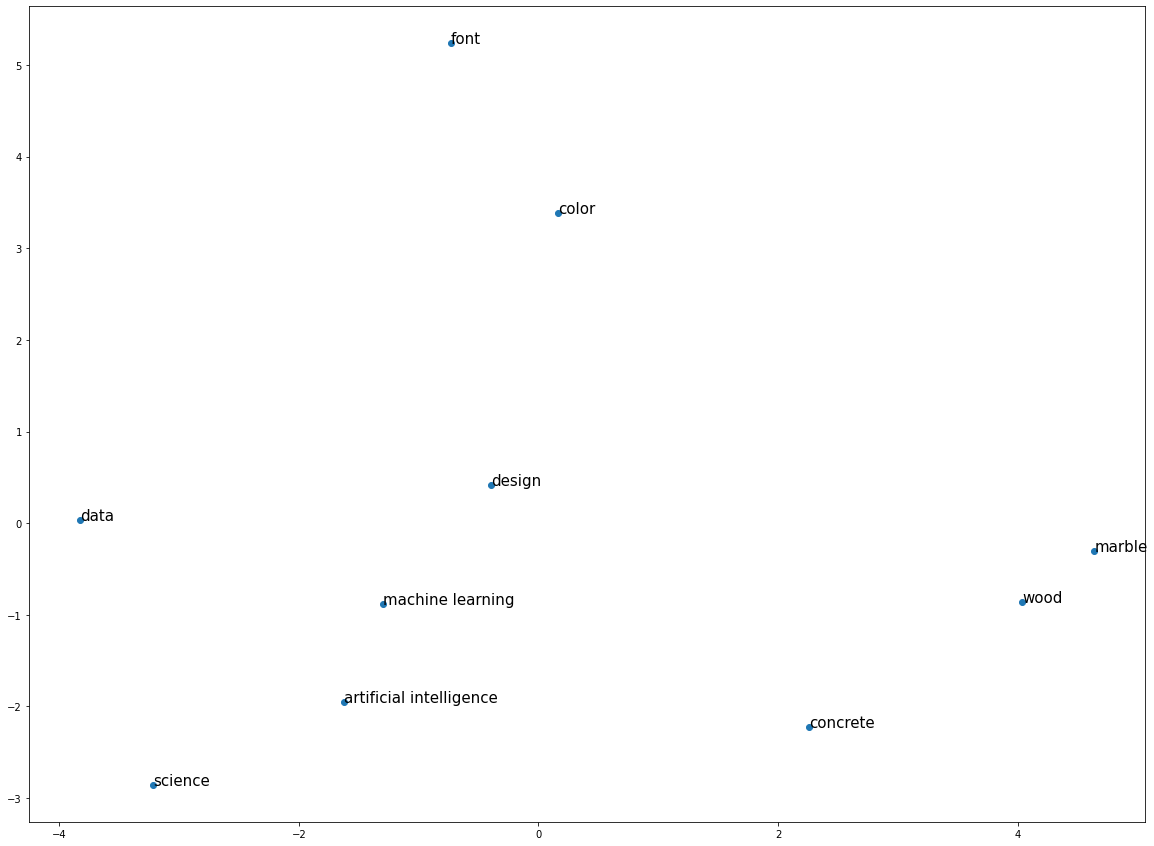

In [ ]:
# create a plot 
plt.figure(figsize=(20,15))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot|
plt.show()

## Follow Along
### Extract Document Vectors

Let's see how much the quality of our query will work when we try a new embedding model.

Steps:
* Extract Vectors from Each Document
* Search using KNN


In [133]:
X = [nlp(str(d)).vector for d in data]

In [135]:
X_df = pd.DataFrame(X)
X_df.shape

(401, 300)

In [136]:
# knn fit
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(X_df)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [144]:
X_df[0].shape, X_df.iloc[0].shape

((401,), (300,))

In [143]:
# knn needs a np.ndarray of 1 sample and 300 features
nn.kneighbors(X_df.iloc[0].values.reshape(1,-1))

(array([[0.        , 0.        , 0.59800228, 0.59800228, 0.63739912]]),
 array([[  0,  85, 257, 245, 253]]))

## Challenge

You will extract word embeddings from documents using Spacy's pre-trained model in the upcoming module project. 

# Review
For your module project assignment you will create vector representations of indeed.com Data Science job listings. You will then estimate a similarity model to perform searches for job descriptions. Get started with your [module project here](./LS_DS_412_Vector_Representations_Assignment.ipynb)

# Sources

* Spacy 101 - https://course.spacy.io
* NLTK Book - https://www.nltk.org/book/
* An Introduction to Information Retrieval - https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf